In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import os
os.environ["PATH"] = "/global/common/software/nersc9/texlive/2024/bin/x86_64-linux:" + os.environ["PATH"]

import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"

import camb
from tqdm import tqdm
from scipy.stats import qmc

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

from multiprocessing import Pool, cpu_count

import joblib
import random


In [3]:
# Function to generate the Pk using CAMB
def get_pk(params):
    h, Omega_c, Omega_b, Asx1e9, ns, mnu = params
    
    # Set up for the P(k)
    z = 0.0
    minkh = 1e-4
    maxkh = 10
    npoints = 5000
    
    pars = camb.CAMBparams()
    
    # Cosmology including massive neutrinos
    pars.set_cosmology(H0=100*h, ombh2=Omega_b*h**2, omch2=Omega_c*h**2, mnu=mnu, num_massive_neutrinos=1)

    # Primordial power spectrum
    pars.InitPower.set_params(As=Asx1e9*1e-9, ns=ns)

    pars.set_matter_power(redshifts=[z], kmax=1.1*maxkh*h, nonlinear=True) # a little bit larger than maxkh*h to give some margin
    results = camb.get_results(pars)
    kh, z_vals, pk = results.get_matter_power_spectrum(
        minkh=minkh, maxkh=maxkh, npoints=npoints
    )

    return kh, pk[0] # kh is always the same since minkh, maxkh and npoints are fixed


In [4]:
# Parameter ranges
h_bounds = [0.55, 0.91]
Omega_c_bounds = [0.1, 0.5]
Omega_b_bounds = [0.03, 0.3]
Asx1e9_bounds = [0.5, 4]
ns_bounds = [0.9, 1.1]
mnu_bounds = [0, 0.6]

# Number of Sobol samples used for emulator training
n_samples = 2 ** 8

# ===============================
# 1. Training (Sobol sequence)
# ===============================

# Generate Sobol samples in [0,1]^6
sampler = qmc.Sobol(d=6, scramble=True)
sample_unit = sampler.random(n_samples)

# Scale to actual parameter values
h_vals       = h_bounds[0]       + sample_unit[:,0] * (h_bounds[1] - h_bounds[0])
Omega_c_vals = Omega_c_bounds[0] + sample_unit[:,1] * (Omega_c_bounds[1] - Omega_c_bounds[0])
Omega_b_vals = Omega_b_bounds[0] + sample_unit[:,2] * (Omega_b_bounds[1] - Omega_b_bounds[0])
Asx1e9_vals  = Asx1e9_bounds[0]  + sample_unit[:,3] * (Asx1e9_bounds[1] - Asx1e9_bounds[0])
ns_vals      = ns_bounds[0]      + sample_unit[:,4] * (ns_bounds[1] - ns_bounds[0])
mnu_vals     = mnu_bounds[0]     + sample_unit[:,5] * (mnu_bounds[1] - mnu_bounds[0])

# Combine into parameter list
param_list = list(zip(
    h_vals,
    Omega_c_vals,
    Omega_b_vals,
    Asx1e9_vals,
    ns_vals,
    mnu_vals
))

# ===============================
# 2. Validation (Uniform random)
# ===============================

# Generate purely random samples in [0,1]^6
sample_unit_validation = np.random.rand(n_samples, 6)

# Scale to actual parameter values
h_vals_val       = h_bounds[0]       + sample_unit_validation[:,0] * (h_bounds[1] - h_bounds[0])
Omega_c_vals_val = Omega_c_bounds[0] + sample_unit_validation[:,1] * (Omega_c_bounds[1] - Omega_c_bounds[0])
Omega_b_vals_val = Omega_b_bounds[0] + sample_unit_validation[:,2] * (Omega_b_bounds[1] - Omega_b_bounds[0])
Asx1e9_vals_val  = Asx1e9_bounds[0]  + sample_unit_validation[:,3] * (Asx1e9_bounds[1] - Asx1e9_bounds[0])
ns_vals_val      = ns_bounds[0]      + sample_unit_validation[:,4] * (ns_bounds[1] - ns_bounds[0])
mnu_vals_val     = mnu_bounds[0]     + sample_unit_validation[:,5] * (mnu_bounds[1] - mnu_bounds[0])

# Combine into parameter list
param_list_validation = list(zip(
    h_vals_val,
    Omega_c_vals_val,
    Omega_b_vals_val,
    Asx1e9_vals_val,
    ns_vals_val,
    mnu_vals_val
))


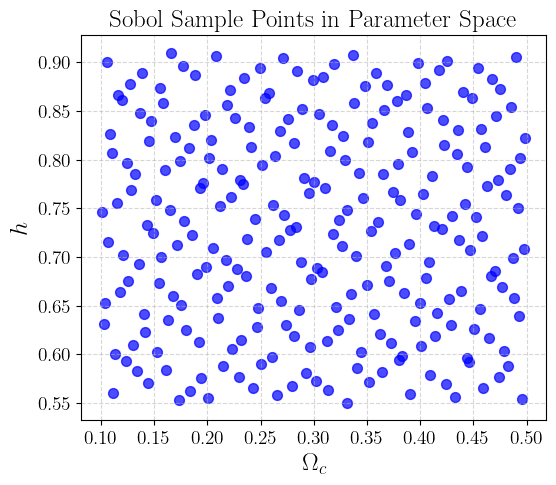

In [5]:
plt.figure(figsize=(6,5))
plt.scatter(Omega_c_vals, h_vals, c='blue', s=50, alpha=0.7)
plt.xlabel(r'$\Omega_c$', fontsize=18)
plt.ylabel(r'$h$', fontsize=18)
plt.title("Sobol Sample Points in Parameter Space", fontsize=18)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


In [6]:
# Compute the P(k) of the Sobol samples (training and validation independently)
def run_parallel(param_list):
    all_pks = []
    
    n_cpus = 5
    with Pool(processes=n_cpus) as pool:
        for kh, pk in tqdm(
            pool.imap(get_pk, param_list),
            total=len(param_list),
            desc="Generating P(k)"
        ):
            all_pks.append(pk)
    
    return all_pks

if __name__ == "__main__":
    all_pks = run_parallel(param_list)
    all_pks_validation = run_parallel(param_list_validation) # I precompute the P(k) I will use for the validation later


Generating P(k): 100%|██████████| 256/256 [01:28<00:00,  2.90it/s]


In [7]:
# ===============================
# 1. Stack P(k) and parameters
# ===============================
pk_array = np.array(all_pks) # shape: (n_samples, n_k)

# Take log of P(k) for PCA
log_pk = np.log(pk_array)

# ===============================
# 2. PCA decomposition
# ===============================
n_components = 10  # number of PCs to keep
pca = PCA(n_components=n_components)
pc_coeffs = pca.fit_transform(log_pk) # shape: (n_samples, n_components)

# ===============================
# 3. Standardize input parameters
# ===============================
scaler = StandardScaler()
params_scaled = scaler.fit_transform(np.array(param_list))

# ===============================
# 4. Train Gaussian Processes for each PC
# ===============================
gps = []

# Set initial length scales proportional to standardized data (~1)
kernel = C(1.0, (1e-3, 1e5)) * RBF(length_scale=np.ones(6), length_scale_bounds=(1e-2, 1e3))

# from sklearn.utils.optimize import _check_optimize_result
# # Custom optimizer with more iterations
# def optimizer(obj_func, initial_theta, bounds):
#     # Run L-BFGS-B
#     opt_res = scipy.optimize.minimize(
#         obj_func, initial_theta, bounds=bounds, method="L-BFGS-B", jac=True, options={"maxiter": 10**9}
#     )
#     _check_optimize_result("lbfgs", opt_res)
#     return opt_res.x, opt_res.fun

for i in tqdm(range(n_components)):
    gp = GaussianProcessRegressor(
        kernel=kernel,
        n_restarts_optimizer=10,  # more restarts for robust convergence
        alpha=1e-6,               # small noise term for stability
        normalize_y=True,
        # optimizer=optimizer
    )
    gp.fit(params_scaled, pc_coeffs[:, i])
    gps.append(gp)

# ===============================
# 5. Save stuff
# ===============================

params_default = [0.67, 0.25, 0.045, 2.1, 0.97, 0.06] # I only want to get kh, so any combination of parameters will work
kh, _ = get_pk(params_default)

# Save k grid
np.save("results/k_grid.npy", kh)

# Save PCA
joblib.dump(pca, "results/pca.pkl")

# Save GP models
joblib.dump(gps, "results/gps.pkl")

# Save scaler
joblib.dump(scaler, "results/scaler.pkl")

# Save parameter bounds
np.savez(
    "results/param_bounds.npz",
    h_bounds=h_bounds,
    Omega_c_bounds=Omega_c_bounds,
    Omega_b_bounds=Omega_b_bounds,
    Asx1e9_bounds=Asx1e9_bounds,
    ns_bounds=ns_bounds,
    mnu_bounds=mnu_bounds,
)

# ===============================
# 6. Prediction function
# ===============================

def predict_pk(params):
    params_scaled = scaler.transform(np.array(params).reshape(1, -1))

    # Predict PC coefficients
    pc_pred = np.array([gp.predict(params_scaled)[0] for gp in gps])

    # Reconstruct log(Pk) and exponentiate
    log_pk_pred = pca.inverse_transform(pc_pred.reshape(1, -1)).flatten()
    pk_pred = np.exp(log_pk_pred)

    return pk_pred


100%|██████████| 10/10 [00:44<00:00,  4.40s/it]


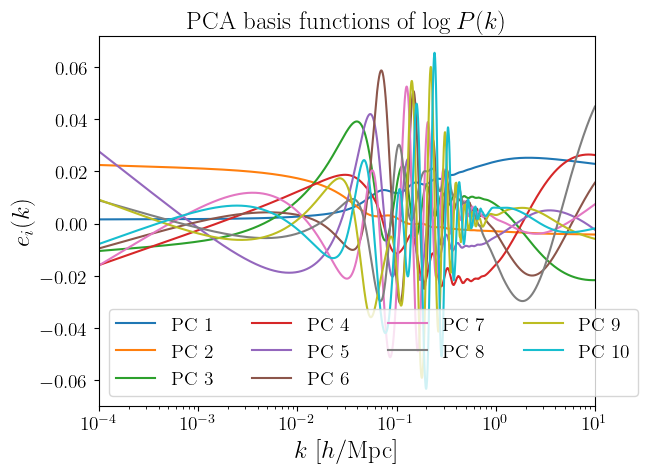

In [8]:
# Plot the PCA decomposition
for i in range(n_components):
    plt.plot(kh, pca.components_[i], label=f'PC {i+1}')

plt.xscale('log')
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$', fontsize=18)
plt.ylabel(r'$e_i(k)$', fontsize=18)
plt.legend(ncol=4, fontsize=14, loc="best")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(r'PCA basis functions of $\log P(k)$', fontsize=18)
plt.xlim(np.min(kh), np.max(kh))
plt.show()


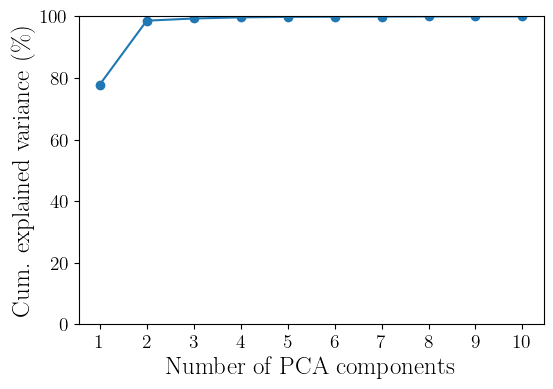

In [9]:
var_ratio = pca.explained_variance_ratio_
cum_var = np.cumsum(var_ratio)

x = np.arange(1, len(cum_var) + 1)

plt.figure(figsize=(6,4))
plt.plot(x, cum_var * 100, marker='o')

plt.xlabel('Number of PCA components', fontsize=18)
plt.ylabel('Cum. explained variance (\%)', fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(x)
plt.ylim(0, 100)
plt.show()


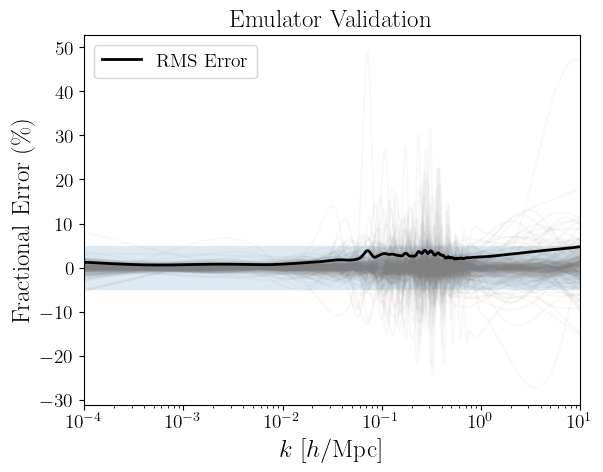

In [10]:
# Validate emulator predictions
all_frac_err = []

for param_validation, pk_true in zip(param_list_validation, all_pks_validation):
    pk_pred = predict_pk(param_validation)
    frac_err = (pk_pred - pk_true) / pk_true
    all_frac_err.append(frac_err)

    plt.plot(kh, frac_err * 100, color='gray', alpha=0.05)

all_frac_err = np.array(all_frac_err) # shape: (n_tests, n_k)

rms_err = np.sqrt(np.mean(all_frac_err**2, axis=0))
max_err = np.max(np.abs(all_frac_err), axis=0)

plt.plot(kh, rms_err*100, color='k', lw=2, label='RMS Error')
# plt.plot(kh, max_err*100, color='r', lw=1.5, label='Max Error')
plt.xscale('log')
plt.xlabel(r'$k \ [h/\mathrm{Mpc}]$', fontsize=18)
plt.ylabel('Fractional Error (\%)', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Emulator Validation', fontsize=18)
plt.xlim(np.min(kh), np.max(kh))
plt.axhspan(-5, 5, alpha=0.15)
plt.legend(fontsize=14)
plt.show()
